# Performance Analysis of textdiff.Unified() for Go Repository

This notebook analyzes performance statistics from diff operations and generates histograms showing the duration distribution for different variants.

## Import Required Libraries

Import pandas, matplotlib, and numpy libraries needed for data processing and visualization.

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

## Load and Read CSV Data

Load the CSV file containing performance statistics data using pandas.

**Note:** Update the `csv_file_path` variable to point to your actual CSV file.

In [68]:
# Update this path to your actual CSV file
csv_file_path = '../stats.csv'  # Adjust this path as needed

# Check if file exists
if os.path.exists(csv_file_path):
    stats = pd.read_csv(csv_file_path)
    print(f"Loaded {len(stats)} records from {csv_file_path}")
    print("\nFirst few rows:")
    display(stats.head())
    print("\nColumns:", stats.columns.tolist())
    print("\nVariants available:", stats['variant'].unique() if 'variant' in stats.columns else 'No variant column found')
else:
    print(f"File not found: {csv_file_path}")
    print("Please update the csv_file_path variable to point to your CSV file.")

Loaded 497016 records from ../stats.csv

First few rows:


,commit_id,file,variant,N,M,D,duration_ns
0,305b4baf41ecbaa3469428b7debb389bd1527804,src/net/http/clientserver_test.go,regular,32,29,7,130500
1,305b4baf41ecbaa3469428b7debb389bd1527804,src/net/http/clientserver_test.go,optimal,32,29,7,55459
2,54875a7a7f64ed3ae2f4d3b66f9de4b3c30c3a22,doc/articles/defer_panic_recover.html,regular,1,0,2,38375
3,54875a7a7f64ed3ae2f4d3b66f9de4b3c30c3a22,doc/articles/defer_panic_recover.html,optimal,1,0,2,13875
4,f5b5939c28ecb8b8c0897584fed78589c27348f6,src/cmd/dist/buildtool.go,regular,4,15,13,41333



Columns: ['commit_id', 'file', 'variant', 'N', 'M', 'D', 'duration_ns']

Variants available: ['regular' 'optimal']


## Define Plotting Function

Create a function to generate performance histograms for each variant using fixed time interval bins: <1ms, 1-5ms, 5-10ms, 10-25ms, 25-50ms, 50-100ms, ≥100ms.

In [69]:
def create_performance_histogram(variant_name, variant_data):
    """
    Create a performance histogram for a specific variant.
    
    Args:
        variant_name (str): Name of the variant (e.g., 'regular', 'optimal')
        variant_data (DataFrame): Filtered data for the specific variant
    """
    # Convert nanoseconds to milliseconds
    duration_ms = variant_data['duration_ns'] / 1_000_000
    
    # Define custom bins: <1ms, <5ms, <10ms, <25ms, <50ms, <100ms, >=100ms
    bins = [0, 1, 5, 10, 25, 50, 100, float('inf')]
    bin_labels = ['<1ms', '1-5ms', '5-10ms', '10-25ms', '25-50ms', '50-100ms', '≥100ms']
    
    # Create histogram with custom bins
    hist, bin_edges = np.histogram(duration_ms, bins=bins)
    
    # Create figure and axes objects explicitly
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create bar chart instead of histogram for better visualization of discrete bins
    x_pos = np.arange(len(bin_labels))
    bars = ax.bar(x_pos, hist, alpha=0.7, edgecolor='black')
    
    # Customize the plot
    ax.set_xlabel('Duration')
    ax.set_ylabel('Frequency')
    ax.set_yscale('log')
    ax.set_title(f'textdiff.Unified(...) for Go repository')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bin_labels, rotation=45, ha='right')

    # Add value labels on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom')
    
    # Add statistics text
    mean_duration = duration_ms.mean()
    median_duration = duration_ms.median()
    max_duration = duration_ms.max()
    total_count = len(duration_ms)
    
    # Format numbers with commas for better readability
    total_formatted = f'{total_count:,}'
    stats_text = f'Total: {total_formatted}\nMean: {mean_duration:.2f}ms\nMedian: {median_duration:.2f}ms\nMax: {max_duration:.2f}ms'
    ax.text(0.98, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='right',
            fontsize=11,
            fontweight='500',
            color='#374151',
            bbox=dict(boxstyle='round,pad=0.8', 
                     facecolor='#F8FAFC', 
                     edgecolor='#CBD5E1',
                     linewidth=1.5,
                     alpha=0.95,
                     mutation_scale=20))
    
    # Display the plot
    plt.tight_layout()
    plt.show()
    
    # Close the figure to free memory
    plt.close(fig)
    
    return {
        'variant': variant_name,
        'count': len(variant_data),
        'mean_ms': mean_duration,
        'median_ms': median_duration,
        'min_ms': duration_ms.min(),
        'max_ms': duration_ms.max(),
        'bin_counts': dict(zip(bin_labels, hist))
    }

## Generate Performance Histograms

Filter data by different variants (regular and optimal) and create histograms for each.

Processing variants: ['regular' 'optimal']

=== Processing regular variant ===
Found 248508 records for regular variant


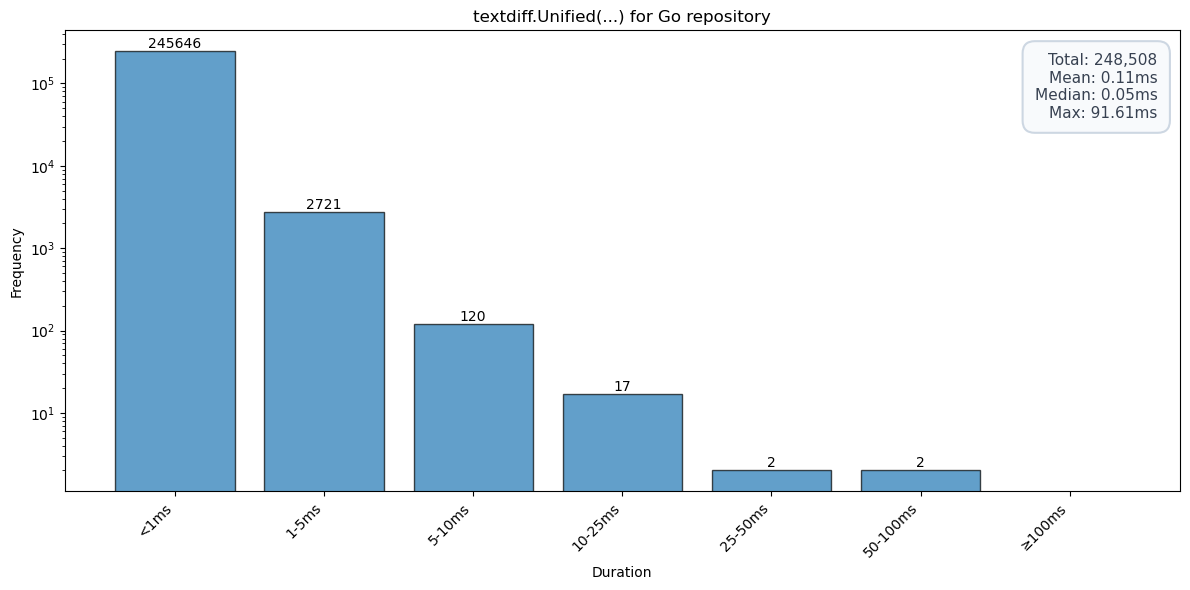


=== Processing optimal variant ===
Found 248508 records for optimal variant


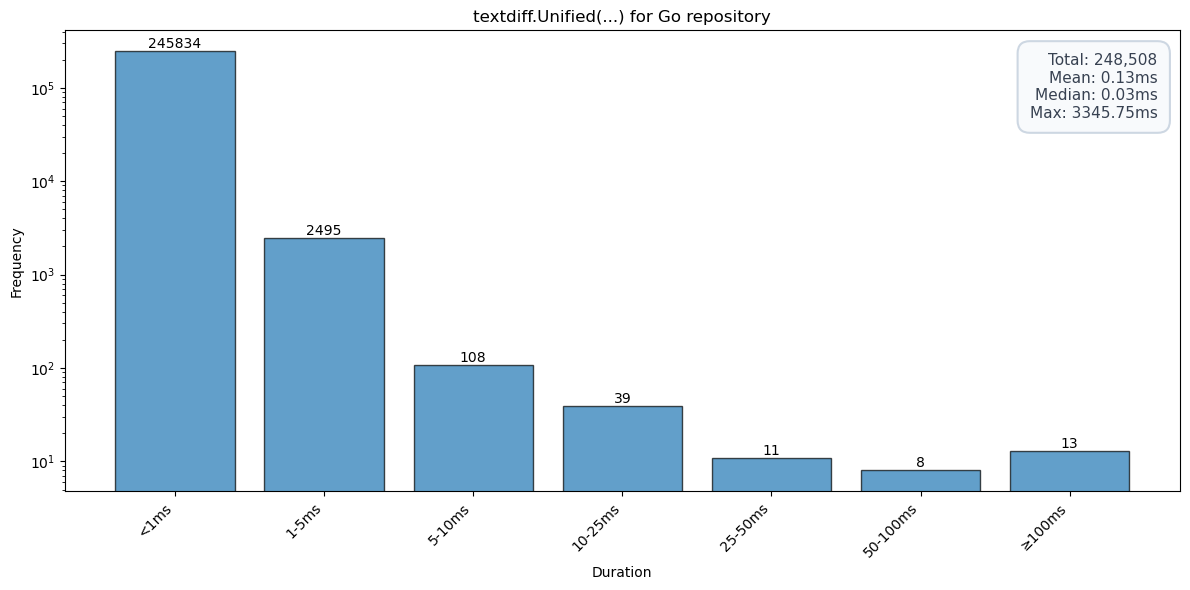


=== Summary Statistics ===


,variant,count,mean_ms,median_ms,min_ms,max_ms,bin_counts
0,regular,248508,0.113328,0.051833,0.000208,91.613584,"{'<1ms': 245646, '1-5ms': 2721, '5-10ms': 120,..."
1,optimal,248508,0.129741,0.028208,0.000166,3345.752291,"{'<1ms': 245834, '1-5ms': 2495, '5-10ms': 108,..."


In [70]:
# Check if data is loaded and has the required columns
if 'stats' in locals() and 'variant' in stats.columns and 'duration_ns' in stats.columns:
    # Get available variants
    available_variants = stats['variant'].unique()
    print(f"Processing variants: {available_variants}")
    
    # Store statistics for summary
    variant_stats = []
    
    # Process each variant
    for variant in available_variants:
        print(f"\n=== Processing {variant} variant ===")
        
        # Filter data for current variant
        variant_data = stats[stats["variant"] == variant]
        print(f"Found {len(variant_data)} records for {variant} variant")
        
        if len(variant_data) > 0:
            # Create histogram for this variant
            stats_summary = create_performance_histogram(variant, variant_data)
            variant_stats.append(stats_summary)
        else:
            print(f"No data found for variant: {variant}")
    
    # Display summary statistics
    if variant_stats:
        print("\n=== Summary Statistics ===")
        summary_df = pd.DataFrame(variant_stats)
        display(summary_df)
        
else:
    print("Data not loaded or missing required columns ('variant', 'duration_ns')")
    print("Please ensure the CSV file is loaded and contains the correct columns.")